# PLV Model Prototype 3

In [25]:
# Install required libraries (uncomment if running in a fresh environment)
# !pip install requests pandas
# !pip install statsmodels

import requests

import pandas as pd
import numpy as np

import json

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Fetch Data from Subgraph API

Send the GraphQL query to the subgraph API endpoint and fetch the response.

In [26]:
def date_to_unix(date_str):
    """Convert a date string in 'YYYY-MM-DD' format to a Unix timestamp."""
    dt = datetime.strptime(date_str, '%Y-%m-%d')
    return int(dt.timestamp())

def make_price_query(pool_address, start_ts, end_ts):
    """Create a GraphQL query string for fetching price, volume, and liquidity of a Uniswap V3 pool."""
    return f"""
    {{
      poolHourDatas(first: 1000, where: {{pool: \"{pool_address}\", periodStartUnix_gte: {start_ts}, periodStartUnix_lte: {end_ts}}}, orderBy: periodStartUnix, orderDirection: asc) {{
        periodStartUnix
        token0Price
        volumeUSD
        liquidity
      }}
    }}
    """

def fetch_pool_hourly_data(api_key, subgraph_id, pool_address, start_date, end_date):
    """
    Fetch hourly price (token0Price as 'price'), volumeUSD, liquidity, and datetimes for a Uniswap V3 pool from the subgraph.
    Dates should be in 'YYYY-MM-DD' format.
    Returns a pandas DataFrame with columns: periodStartUnix, price, volumeUSD, liquidity
    """
    start_ts = date_to_unix(start_date)
    end_ts = date_to_unix(end_date)
    all_data = []
    last_ts = start_ts
    while True:
        graphql_query = make_price_query(pool_address, last_ts, end_ts)
        payload = {
            "query": graphql_query,
            "operationName": "Subgraphs",
            "variables": {}
        }
        url = f"https://gateway.thegraph.com/api/subgraphs/id/{subgraph_id}"
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        response = requests.post(url, json=payload, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Query failed with status code {response.status_code}: {response.text}")
        result = response.json()
        hour_data = result['data']['poolHourDatas']
        if not hour_data:
            break
        all_data.extend(hour_data)
        if len(hour_data) < 1000:
            break
        # Update last_ts to one after the last returned timestamp to avoid overlap
        last_ts = int(hour_data[-1]['periodStartUnix']) + 1

    df = pd.DataFrame(all_data)
    if not df.empty:
        df['periodStartUnix'] = pd.to_datetime(df['periodStartUnix'], unit='s')
        df = df.rename(columns={"token0Price": "price"})
        df['price'] = pd.to_numeric(df['price'])
        df['volumeUSD'] = pd.to_numeric(df['volumeUSD'])
        df['liquidity'] = pd.to_numeric(df['liquidity'], errors='coerce', downcast=None).astype(float)
    return df

In [27]:
# Define training and test pool addresses
api_key = "d1762c97d76a973e078c5536742bd237"  # Replace with your API key
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"    # Replace with your subgraph id

# Pool address to test on (should be in the same format)
pool_address = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"  # Example test pool

start_date = "2024-06-01"
end_date = "2025-06-01"

# Fetch the pool
print(f"Fetching data for pool: {pool_address}")
df = fetch_pool_hourly_data(api_key, subgraph_id, pool_address, start_date, end_date)

print(f"Data shape: {df.shape}")

Fetching data for pool: 0xcbcdf9626bc03e24f779434178a73a0b4bad62ed
Data shape: (8125, 4)


## Feature Engineering: Price Returns, Volatility, Moving Averages, and Time Features

In this section, we compute engineered features for the PLV model, including:
- Price returns (log and simple)
- Rolling volatility (e.g., 6-hour standard deviation)
- Moving averages (e.g., 6-hour, 24-hour)
- Time-based features (hour of day, day of week, month, season)

These features are useful for modeling and backtesting strategies on Uniswap V3 pool data.

In [28]:
# Feature engineering function (reuse from earlier)
def feature_engineering(df):
    df = df.copy()

    if 'datetime' not in df.columns:
        df['datetime'] = pd.to_datetime(df['periodStartUnix'], unit='s')
    df = df.sort_values('datetime').reset_index(drop=True)

    # Returns
    df['price_return'] = df['price'].pct_change()
    df['liquidity_return'] = df['liquidity'].pct_change()
    df['volume_return'] = df['volumeUSD'].pct_change()

    # Outlier removal
    def remove_outliers_iqr(series, k=3.0):
        q_01 = series.quantile(0.3)
        q_90 = series.quantile(0.6)
        iqr = q_90 - q_01
        lower = q_01 - k * iqr
        upper = q_90 + k * iqr
        return series.where((series >= lower) & (series <= upper))

    for col in ['price_return', 'liquidity_return', 'volume_return']:
        if col in df.columns:
            df[col] = remove_outliers_iqr(df[col])
            df[col] = df[col].interpolate(method='linear', limit_direction='both')

    # Price-based volatility and moving averages
    df['price_volatility_3h'] = df['price_return'].rolling(window=3).std()
    df['price_volatility_6h'] = df['price_return'].rolling(window=6).std()
    df['price_volatility_24h'] = df['price_return'].rolling(window=24).std()
    df['price_ma_3h'] = df['price_return'].rolling(window=3).mean()
    df['price_ma_6h'] = df['price_return'].rolling(window=6).mean()
    df['price_ma_24h'] = df['price_return'].rolling(window=24).mean()

    # Liquidity-based volatility and moving averages (shifted by 1 to avoid lookahead bias)
    df['liquidity_volatility_3h'] = df['liquidity_return'].shift(1).rolling(window=3).std()
    df['liquidity_volatility_6h'] = df['liquidity_return'].shift(1).rolling(window=6).std()
    df['liquidity_volatility_24h'] = df['liquidity_return'].shift(1).rolling(window=24).std()
    df['liquidity_ma_3h'] = df['liquidity_return'].shift(1).rolling(window=3).mean()
    df['liquidity_ma_6h'] = df['liquidity_return'].shift(1).rolling(window=6).mean()
    df['liquidity_ma_24h'] = df['liquidity_return'].shift(1).rolling(window=24).mean()

    # Temporal features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month

    def get_season(month):
        if month in [12, 1, 2]:
            return 0  # Winter
        elif month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        else:
            return 3  # Fall

    df['season'] = df['month'].apply(get_season)

    if 'periodStartUnix' in df.columns:
        df = df.drop(columns=['periodStartUnix'])

    return df


# Prepare lagged features for a given DataFrame
def add_lagged_features(df, n_lags=3):
    df = df.copy()
    for lag in range(1, n_lags + 1):
        df[f'price_return_lag{lag}'] = df['price_return'].shift(lag)
        df[f'liquidity_return_lag{lag}'] = df['liquidity_return'].shift(lag)
    return df

df_fe = feature_engineering(df)
df_fe = add_lagged_features(df_fe, n_lags=3)

## Analytical Plots: Feature Exploration

Let's visualize the main features and their relationships to better understand the data and engineered features. We'll plot time series, histograms, and scatter plots for key variables.

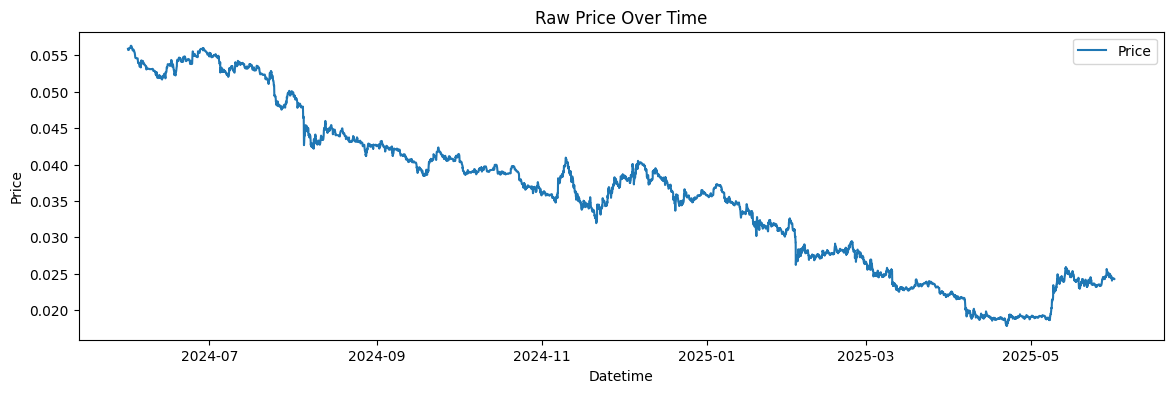

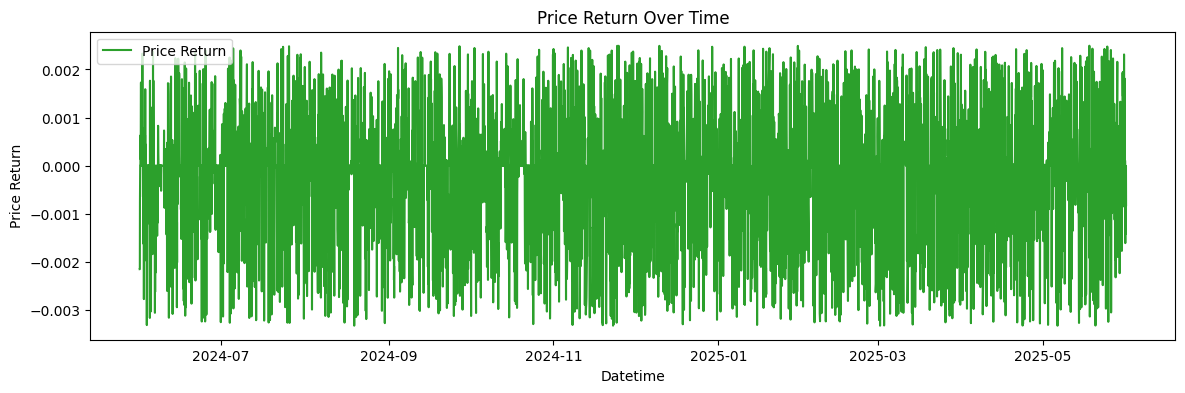

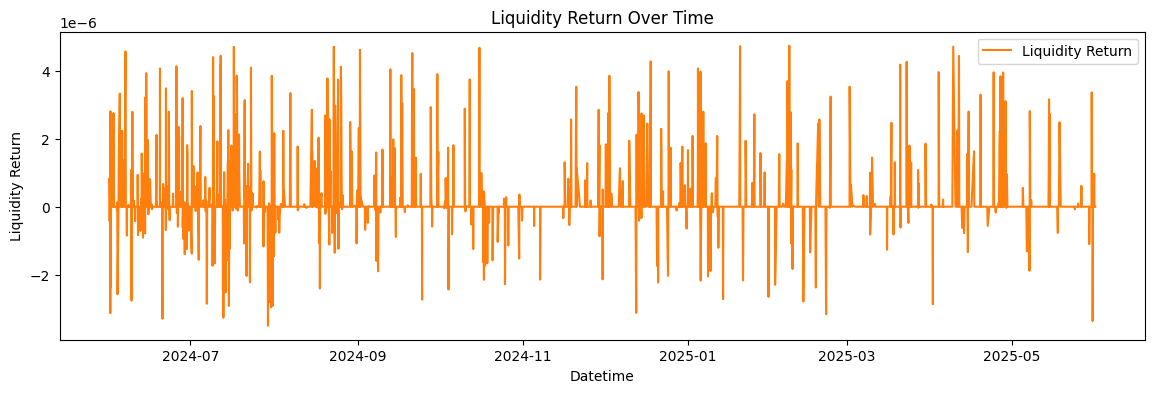

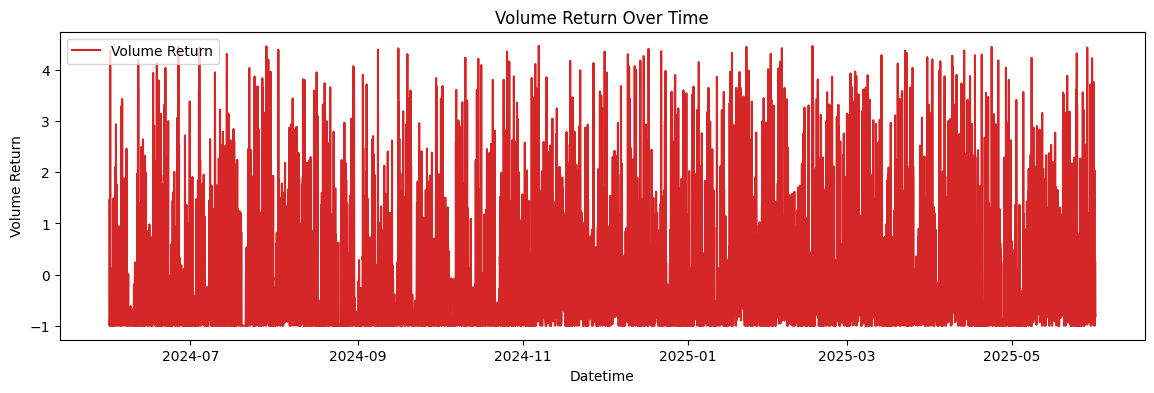

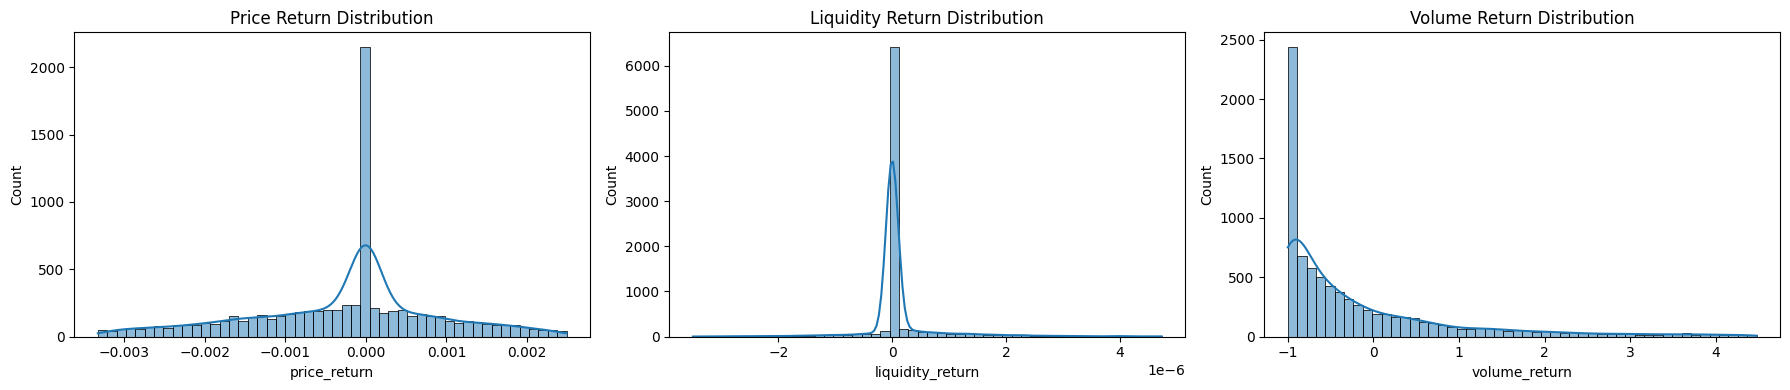

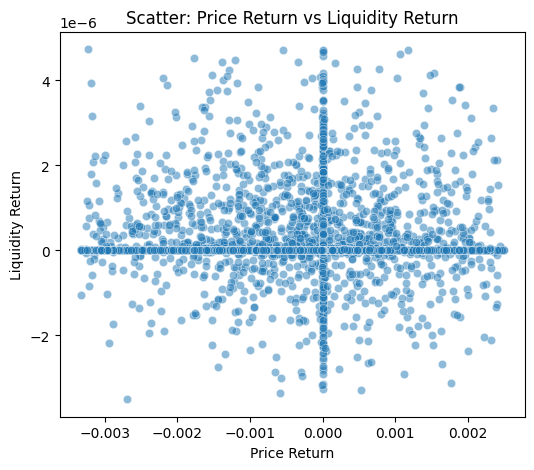

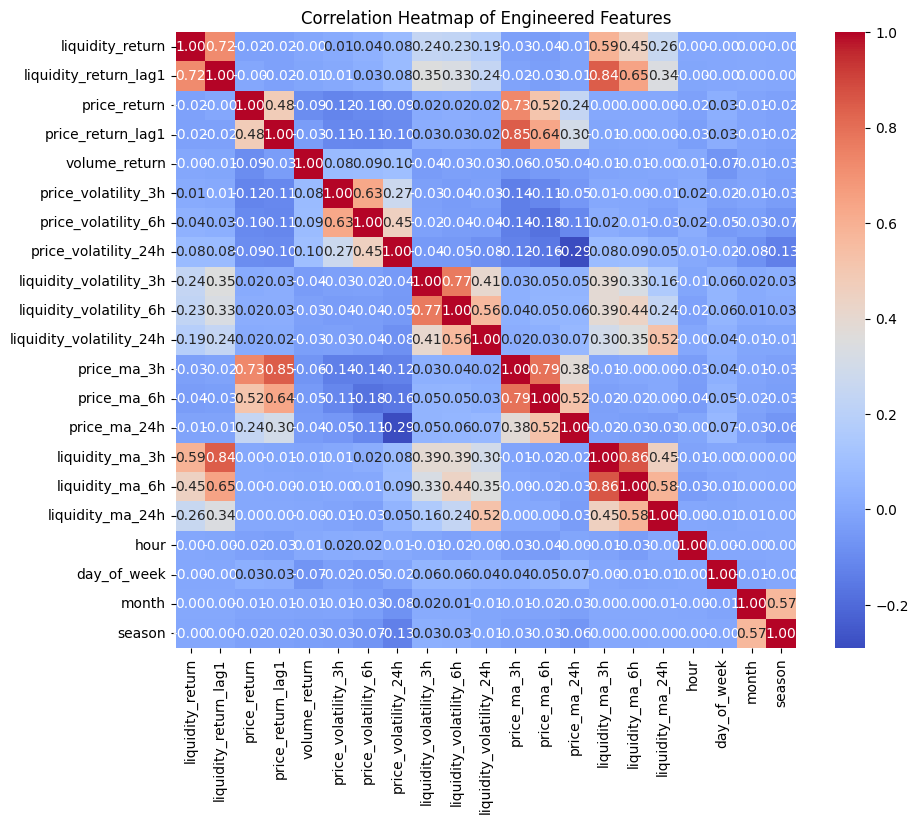

In [29]:
# Plot raw price over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe['datetime'], df_fe['price'], label='Price', color='tab:blue')
plt.title('Raw Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot price return over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe['datetime'], df_fe['price_return'], label='Price Return', color='tab:green')
plt.title('Price Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price Return')
plt.legend()
plt.show()

# Plot liquidity return over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe['datetime'], df_fe['liquidity_return'], label='Liquidity Return', color='tab:orange')
plt.title('Liquidity Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Liquidity Return')
plt.legend()
plt.show()

# Plot volume return over time
plt.figure(figsize=(14, 4))
plt.plot(df_fe['datetime'], df_fe['volume_return'], label='Volume Return', color='tab:red')
plt.title('Volume Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Volume Return')
plt.legend()
plt.show()

# Histograms of returns
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df_fe['price_return'].dropna(), bins=50, ax=axs[0], kde=True)
axs[0].set_title('Price Return Distribution')
sns.histplot(df_fe['liquidity_return'].dropna(), bins=50, ax=axs[1], kde=True)
axs[1].set_title('Liquidity Return Distribution')
sns.histplot(df_fe['volume_return'].dropna(), bins=50, ax=axs[2], kde=True)
axs[2].set_title('Volume Return Distribution')
plt.tight_layout()
plt.show()

# Scatter plot: price_return vs liquidity_return
plt.figure(figsize=(6, 5))
sns.scatterplot(x=df_fe['price_return'], y=df_fe['liquidity_return'], alpha=0.5)
plt.title('Scatter: Price Return vs Liquidity Return')
plt.xlabel('Price Return')
plt.ylabel('Liquidity Return')
plt.show()

# Correlation heatmap of engineered features
features = [
    'liquidity_return', 'liquidity_return_lag1', 
    'price_return', 'price_return_lag1', 
    'volume_return',
    'price_volatility_3h', 'price_volatility_6h', 'price_volatility_24h',
    'liquidity_volatility_3h', 'liquidity_volatility_6h', 'liquidity_volatility_24h',
    'price_ma_3h', 'price_ma_6h', 'price_ma_24h',
    'liquidity_ma_3h', 'liquidity_ma_6h', 'liquidity_ma_24h',
    'hour', 'day_of_week', 'month', 'season'
]
plt.figure(figsize=(10, 8))
sns.heatmap(df_fe[features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

## Stationarity Check

To ensure robust modeling, we check the stationarity of the price, price returns, and log returns using the Augmented Dickey-Fuller (ADF) test. Stationary series are required for many time series models.

In [30]:
from statsmodels.tsa.stattools import adfuller

# Helper function for ADF test
def adf_test(series, name):
    clean_series = series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(clean_series) < 10:
        print(f"Not enough valid data for {name} to run ADF test.")
        return
    result = adfuller(clean_series)
    print(f"ADF Statistic for {name}: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4g}")
    for key, value in result[4].items():
        print(f"    Critical Value {key}: {value:.4f}")
    print("Stationary" if result[1] < 0.05 else "Not stationary", "\n")
print("--- Stationarity Check ---")
adf_test(df_fe['price'], 'price')
adf_test(df_fe['price_return'], 'price_return')
adf_test(df_fe['liquidity_return'], 'liquidity_return')

--- Stationarity Check ---
ADF Statistic for price: -1.5745
p-value: 0.4964
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Not stationary 

ADF Statistic for price_return: -46.8497
p-value: 0
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Stationary 

ADF Statistic for liquidity_return: -15.8295
p-value: 9.981e-29
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Stationary 



## Benchmark Model and Evaluation Functions

We start with a naive benchmark model that predicts the next value as the current value (a persistence or "random walk" model). We also define evaluation functions (e.g., MAE, RMSE, MAPE) to assess model performance. These functions can be reused for more sophisticated models later.

In [31]:
# Prepare training data: only use up to 80% chronologically from each pool
def get_chronological_split(df, split=0.8):
    df = df.sort_values('datetime').reset_index(drop=True)
    split_idx = int(len(df) * split)
    return df.iloc[:split_idx], df.iloc[split_idx:]

In [32]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def naive_predict(series):
    """Naive model: predicts next value as the current value (persistence)."""
    # Shift series by 1 to get prediction for t+1 at time t
    return series.shift(1)

def evaluate_predictions(y_true, y_pred):
    """Compute MAE, RMSE, and MAPE for predictions."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted Liquidity Return"):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true.index, y_true, label="Actual", color="tab:blue")
    plt.plot(y_true.index, y_pred, label="Predicted", color="tab:orange")
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Liquidity Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [33]:
# Example: Benchmark for price prediction
test_split = 0.9
_, test_df = get_chronological_split(df_fe, split=test_split)
y_true = test_df['liquidity_return'].iloc[1:]  # true values from t=1
naive_pred = naive_predict(test_df['liquidity_return']).iloc[1:]  # predictions for t=1 onward
results = evaluate_predictions(y_true, naive_pred)
print("Naive benchmark results for liquidity_return:", results)

Naive benchmark results for liquidity_return: {'MAE': 1.0142035732696835e-07, 'RMSE': np.float64(3.699614343833765e-07), 'MAPE': nan}


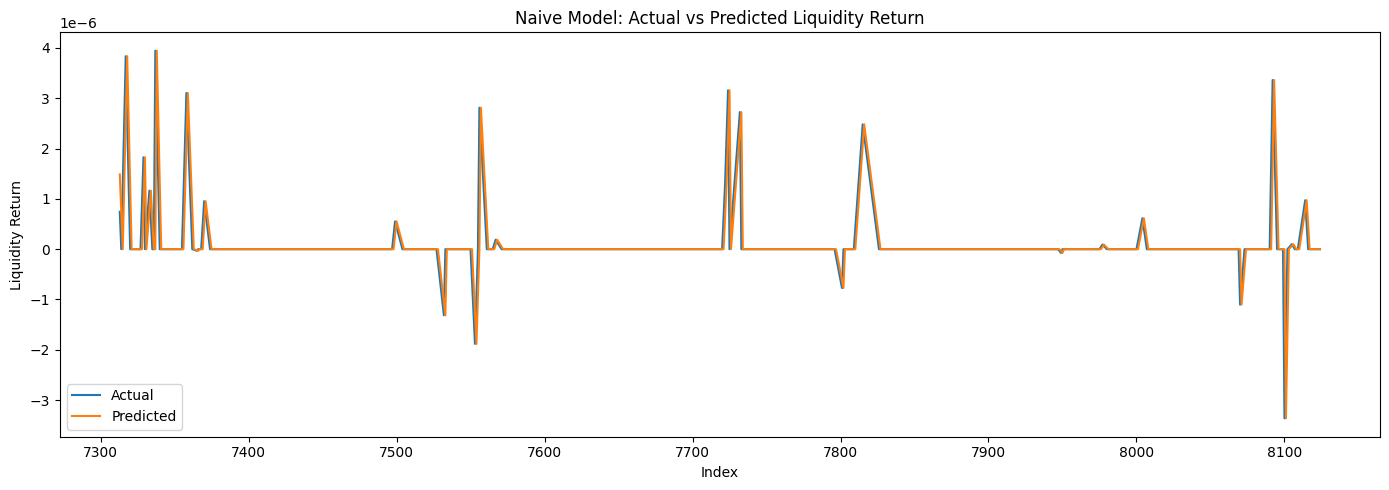

In [34]:
# Plot for Naive Benchmark Model
plot_actual_vs_predicted(y_true, naive_pred, title="Naive Model: Actual vs Predicted Liquidity Return")

## XGBoost: Zero-inflated Regression

In [35]:
# --- ZeroInflatedRegressor class for zero-inflated modeling ---
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import numpy as np
import xgboost as xgb

class ZeroInflatedRegressor(BaseEstimator):
    """
    Zero-inflated regression model: fits a classifier for zero/nonzero, and a regressor for nonzero targets.
    """
    def __init__(
        self,
        classifier=None,
        regressor=None,
        n_lags=3,
        random_state=42
    ):
        self.classifier = classifier or xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=random_state)
        self.regressor = regressor or xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=random_state)
        self.n_lags = n_lags
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        self.fitted = False

    def fit(self, X, y):
        y_cls = (y == 0).astype(int)
        X_scaled = self.x_scaler.fit_transform(X)
        self.classifier.fit(X_scaled, y_cls)
        non_zero_idx = y != 0
        y_nz = y[non_zero_idx].values.reshape(-1, 1)
        self.y_scaler.fit(y_nz)
        y_reg_scaled = self.y_scaler.transform(y_nz).flatten()
        self.regressor.fit(X_scaled[non_zero_idx], y_reg_scaled)
        self.fitted = True
        return self

    def predict(self, X):
        if not self.fitted:
            raise RuntimeError("Model must be fitted before predicting.")
        X_scaled = self.x_scaler.transform(X)
        cls_pred = self.classifier.predict(X_scaled)
        reg_pred_scaled = np.zeros(len(X_scaled))
        non_zero_pred_idx = cls_pred == 0
        if np.any(non_zero_pred_idx):
            reg_pred_scaled[non_zero_pred_idx] = self.regressor.predict(X_scaled[non_zero_pred_idx])
        reg_pred = self.y_scaler.inverse_transform(reg_pred_scaled.reshape(-1, 1)).flatten()
        reg_pred[cls_pred == 1] = 0
        return reg_pred, cls_pred

    def score(self, X, y):
        reg_pred, cls_pred = self.predict(X)
        y_cls = (y == 0).astype(int)
        acc = accuracy_score(y_cls, cls_pred)
        rmse = mean_squared_error(y, reg_pred)
        return {"Classifier accuracy": acc, "Conditional regression RMSE": rmse}

    # def recursive_forecast(self, df, features, forecast_horizon=20):
    #     """
    #     Recursive multi-step forecast using the fitted ZeroInflatedRegressor, updating lagged and rolling features.
    #     df: DataFrame with all features (including price/time/rolling features)
    #     features: list of feature columns to use for prediction
    #     forecast_horizon: number of steps to forecast
    #     Returns: list of predicted liquidity_return values
    #     """
    #     import pandas as pd
    #     df = df.copy()
    #     preds = []
    #     n_lags = self.n_lags
    #     # Use all but last forecast_horizon rows as history
    #     history = df.iloc[:-forecast_horizon].copy()
    #     for step in range(forecast_horizon):
    #         last_idx = history.index[-1]
    #         next_idx = last_idx + 1
    #         # Compose next row's features
    #         next_row = self._update_rolling_features(df, next_idx, features, history)
    #         print(f"Step {step + 1}/{forecast_horizon}, Predicting for index {next_idx} with features: {next_row}")
    #         X_next = pd.DataFrame([next_row], index=[next_idx])[features]
    #         # Predict using classifier+regressor
    #         X_next_scaled = self.x_scaler.transform(X_next)
    #         cls_pred = self.classifier.predict(X_next_scaled)
    #         reg_pred_scaled = 0.0
    #         if cls_pred[0] == 0:
    #             reg_pred_scaled = self.regressor.predict(X_next_scaled)[0]
    #             reg_pred = self.y_scaler.inverse_transform([[reg_pred_scaled]])[0, 0]
    #         else:
    #             reg_pred = 0.0
    #         preds.append(reg_pred)
    #         # Add new row to history for next step
    #         new_row = df.loc[next_idx].copy() if next_idx in df.index else pd.Series(index=df.columns)
    #         new_row['liquidity_return'] = reg_pred
    #         history = pd.concat([history, pd.DataFrame([new_row], index=[next_idx])])
    #     return preds

    # @staticmethod
    # def _update_rolling_features(df, next_idx, features, history):
    #     """
    #     Helper to compute next row's lagged and rolling features for recursive forecasting.
    #     """
    #     next_row = {}
    #     for col in features:
    #         if 'liquidity' in col:
    #             if col.endswith("return"):
    #                 # For liquidity returns, use the last value from history
    #                 next_row[col] = history[col].iloc[-1] if not history[col].empty else np.nan
    #             elif 'volatility' in col:
    #                 # For volatility, compute rolling std from history
    #                 win = int(col.split('_')[-1][:-1])
    #                 next_row[col] = history['liquidity_return'].iloc[-win:].std()
    #             elif 'ma' in col:
    #                 # For moving averages, compute rolling mean from history
    #                 win = int(col.split('_')[-1][:-1])
    #                 next_row[col] = history['liquidity_return'].iloc[-win:].mean() 
    #             elif 'lag' in col:
    #                 # For lagged features, use the last value from history
    #                 lag_num = int(col.split('lag')[-1])
    #                 next_row[col] = history[col].iloc[-lag_num] if len(history) >= lag_num else np.nan
    #         else:
    #             next_row[col] = df.loc[next_idx, col] if next_idx in df.index else np.nan
    #     return next_row

    def recursive_forecast(self, df, features, forecast_horizon=20):
        """
        Recursive multi-step forecast using the fitted ZeroInflatedRegressor, updating lagged and rolling features.
        df: DataFrame with all features (including price/time/rolling features)
        features: list of feature columns to use for prediction
        forecast_horizon: number of steps to forecast
        Returns: list of predicted liquidity_return values
        """
        import pandas as pd

        df = df.copy()
        preds = []
        history = df.iloc[:-forecast_horizon].copy()

        for step in range(forecast_horizon):
            next_idx = history.index[-1] + 1

            # Compose next row's features
            next_row = self._update_rolling_features(df, next_idx, features, history)
            print(f"Step {step + 1}/{forecast_horizon}, Predicting for index {next_idx} with features: {next_row}")

            X_next = pd.DataFrame([next_row], index=[next_idx])[features]
            X_scaled = self.x_scaler.transform(X_next)

            cls_pred = self.classifier.predict(X_scaled)[0]
            if cls_pred == 0:
                reg_scaled = self.regressor.predict(X_scaled)[0]
                reg_pred = self.y_scaler.inverse_transform([[reg_scaled]])[0, 0]
            else:
                reg_pred = 0.0

            preds.append(reg_pred)

            # Add new row to history for next step
            new_row = df.loc[next_idx].copy() if next_idx in df.index else pd.Series(index=df.columns)
            new_row['liquidity_return'] = reg_pred
            history = pd.concat([history, pd.DataFrame([new_row], index=[next_idx])])

        return preds


    @staticmethod
    def _update_rolling_features(df, next_idx, features, history):
        """
        Helper to compute next row's lagged and rolling features for recursive forecasting.
        """
        import numpy as np

        next_row = {}

        for col in features:
            if 'liquidity' not in col:
                # Non-liquidity features: take from df if available
                next_row[col] = df.loc[next_idx, col] if next_idx in df.index else np.nan
                continue

            # Liquidity-based features
            if col.endswith('return'):
                next_row[col] = history[col].iloc[-1] if not history[col].empty else np.nan
            elif 'volatility' in col:
                try:
                    win = int(col.split('_')[-1][:-1])
                    next_row[col] = history['liquidity_return'].iloc[-win:].std()
                except Exception:
                    next_row[col] = np.nan
            elif 'ma' in col:
                try:
                    win = int(col.split('_')[-1][:-1])
                    next_row[col] = history['liquidity_return'].iloc[-win:].mean()
                except Exception:
                    next_row[col] = np.nan
            elif 'lag' in col:
                try:
                    lag_num = int(col.split('lag')[-1])
                    next_row[col] = history[col].iloc[-lag_num] if len(history) >= lag_num else np.nan
                except Exception:
                    next_row[col] = np.nan
            else:
                next_row[col] = np.nan  # fallback for unexpected patterns

        return next_row


# --- Automated Grid Search for ZeroInflatedRegressor (auto lag feature creation & split) ---
def grid_search_zero_inflated(
    df,
    base_features,
    target_col,
    zir_param_grid,
    regressor_class,
    validation_split=0.2,
    metric='rmse',
    verbose=True
):
    """
    Automated grid search for ZeroInflatedRegressor.
    - df: DataFrame with all features and target
    - base_features: list of feature names (excluding lags)
    - target_col: name of target column
    - zir_param_grid: dict, must include 'n_lags' (list of ints)
    - regressor_class: regressor class to use
    - validation_split: fraction of data for validation (e.g. 0.2)
    - metric: 'rmse' or 'mae'
    Returns best model, best params, and results list.
    """
    best_score = float('inf')
    best_params = None
    best_model = None
    results = []
    for params in ParameterGrid(zir_param_grid):
        n_lags = params.get('n_lags', 3)
        # Create lagged features
        df_lagged = add_lagged_features(df, n_lags=n_lags)
        features = base_features + \
            [f'price_return_lag{lag}' for lag in range(1, n_lags + 1)] + \
            [f'liquidity_return_lag{lag}' for lag in range(1, n_lags + 1)]
        # Drop rows with NaNs in features or target
        mask = df_lagged[features + [target_col]].notnull().all(axis=1)
        df_lagged = df_lagged.loc[mask].reset_index(drop=True)
        X = df_lagged[features]
        y = df_lagged[target_col]
        # Chronological split
        split_idx = int(len(X) * (1 - validation_split))
        X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]
        # Extract classifier/regressor params
        clf_params = {k.replace('classifier__', ''): v for k, v in params.items() if k.startswith('classifier__')}
        reg_params = {k.replace('regressor__', ''): v for k, v in params.items() if k.startswith('regressor__')}
        reg_params.update({k: v for k, v in params.items() if not k.startswith('classifier__') and not k.startswith('regressor__') and k != 'n_lags'})
        # Always use XGBoost for classifier
        classifier = xgb.XGBClassifier(random_state=42, **clf_params)
        regressor = regressor_class(**reg_params)
        model = ZeroInflatedRegressor(
            classifier=classifier,
            regressor=regressor,
            n_lags=n_lags
        )
        model.fit(X_train, y_train)
        reg_pred, cls_pred = model.predict(X_val)
        if metric == 'rmse':
            score = mean_squared_error(y_val, reg_pred)
        elif metric == 'mae':
            score = np.mean(np.abs(y_val - reg_pred))
        else:
            raise ValueError("Unsupported metric")
        results.append((params, score))
        if verbose:
            print(f"Params: {params}, Val {metric.upper()}: {score}")
        if score < best_score:
            best_score = score
            best_params = params
            best_model = model
    if verbose:
        print(f"\nBest params: {best_params}, Best Val {metric.upper()}: {best_score}")
    return best_model, best_params, results

def plot_zero_inflated_confusion(y_true, y_pred_cls, title="ZeroInflatedRegressor: Zero Classification Confusion Matrix"):
    """
    Plot confusion matrix for zero/non-zero classification in ZeroInflatedRegressor.
    y_true: true target values (regression target)
    y_pred_cls: predicted class labels (0=non-zero, 1=zero)
    """
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix((y_true == 0).astype(int), y_pred_cls)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Zero", "Zero"])
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.grid(False)
    plt.show()


ZeroInflatedRegressor (Auto Grid Search) metrics: {'Classifier accuracy': 0.9395807644882861, 'Conditional regression RMSE': 1.0564223582164165e-13}


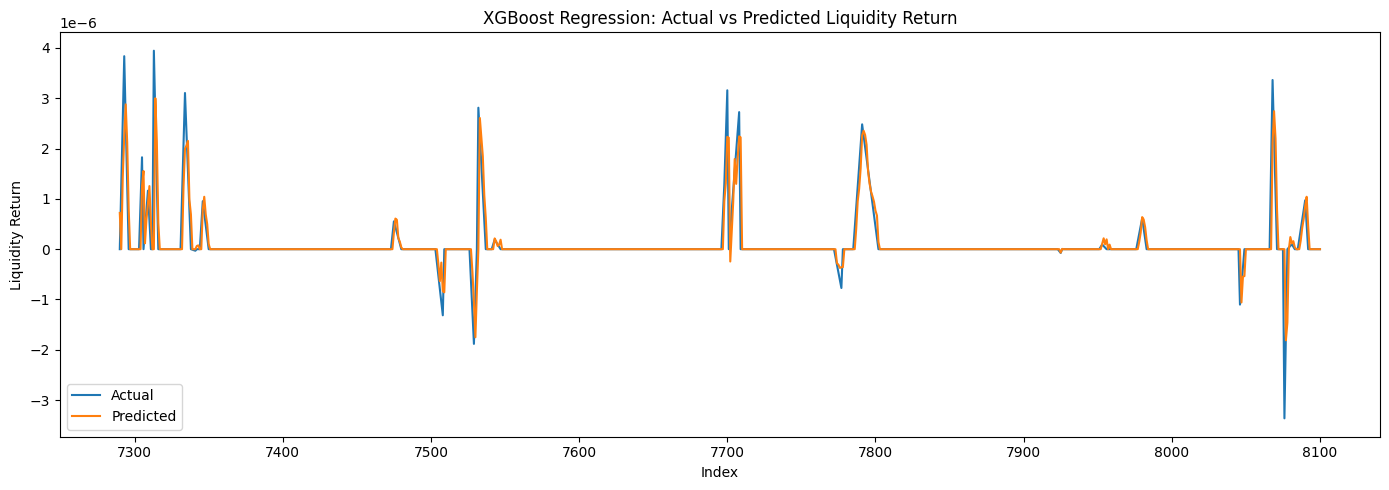

In [43]:
# --- Example usage XGBoost Regressor ---

base_features = [
    'price_return', 
    'price_volatility_3h', 'price_volatility_6h', 'price_volatility_24h',
    'liquidity_volatility_3h', 'liquidity_volatility_6h', 'liquidity_volatility_24h',
    'price_ma_3h', 'price_ma_6h', 'price_ma_24h',
    'liquidity_ma_3h', 'liquidity_ma_6h', 'liquidity_ma_24h',
    'hour', 'day_of_week', 'month', 'season'
]

param_grid = {
    'classifier__n_estimators': [50],
    'classifier__max_depth': [2],
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [2, 3],
    'n_lags': [3, 5],
}
best_zir, best_params, grid_results = grid_search_zero_inflated(
    df=df_fe,
    base_features=base_features,
    target_col='liquidity_return',
    zir_param_grid=param_grid,
    regressor_class=xgb.XGBRegressor,
    validation_split=0.2,
    metric='rmse',
    verbose=False
)

# Evaluate on test set (using best n_lags/features)
df_lagged = add_lagged_features(df_fe, n_lags=best_params['n_lags'])
features = base_features + [f'price_return_lag{lag}' for lag in range(1, best_params['n_lags'] + 1)] + [f'liquidity_return_lag{lag}' for lag in range(1, best_params['n_lags'] + 1)]
mask = df_lagged[features + ['liquidity_return']].notnull().all(axis=1)
df_lagged = df_lagged.loc[mask].reset_index(drop=True)
X = df_lagged[features]
y = df_lagged['liquidity_return']
split_idx = int(len(X) * test_split)
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]
reg_pred, cls_pred = best_zir.predict(X_test)
metrics = best_zir.score(X_test, y_test)
print("ZeroInflatedRegressor (Auto Grid Search) metrics:", metrics)
plot_actual_vs_predicted(y_test, reg_pred, title="XGBoost Regression: Actual vs Predicted Liquidity Return")

# --- Example usage SGD Regressor---
# param_grid = {
#     'classifier__n_estimators': [50],
#     'classifier__max_depth': [2],
#     'n_lags': [3, 5],
# }
# best_zir, best_params, grid_results = grid_search_zero_inflated(
#     df=df_fe,
#     base_features=base_features,
#     target_col='liquidity_return',
#     zir_param_grid=param_grid,
#     regressor_class=SGDRegressor,
#     validation_split=0.2,
#     metric='rmse',
#     verbose=False
# )

# # Evaluate on test set (using best n_lags/features)
# df_lagged = add_lagged_features(df_fe, n_lags=best_params['n_lags'])
# features = base_features + [f'price_return_lag{lag}' for lag in range(1, best_params['n_lags'] + 1)] + [f'liquidity_return_lag{lag}' for lag in range(1, best_params['n_lags'] + 1)]
# mask = df_lagged[features + ['liquidity_return']].notnull().all(axis=1)
# df_lagged = df_lagged.loc[mask].reset_index(drop=True)
# X = df_lagged[features]
# y = df_lagged['liquidity_return']
# split_idx = int(len(X) * (1 - 0.2))
# X_test = X.iloc[split_idx:]
# y_test = y.iloc[split_idx:]
# reg_pred, cls_pred = best_zir.predict(X_test)
# metrics = best_zir.score(X_test, y_test)
# print("ZeroInflatedRegressor (Auto Grid Search) metrics:", metrics)
# plot_actual_vs_predicted(y_test, reg_pred, title="SGDRegressor Regression: Actual vs Predicted Liquidity Return")


Grid search results: 8 configurations evaluated
Best parameters: {'classifier__max_depth': 2, 'classifier__n_estimators': 50, 'n_lags': 3, 'regressor__max_depth': 2, 'regressor__n_estimators': 50}
Forecast horizon: 812 steps
Step 1/812, Predicting for index 7313 with features: {'price_return': np.float64(0.0008947888100985235), 'price_volatility_3h': np.float64(0.0005976947377996589), 'price_volatility_6h': np.float64(0.0004892754376118967), 'price_volatility_24h': np.float64(0.0013967161587321564), 'liquidity_volatility_3h': np.float64(3.8935956021826814e-07), 'liquidity_volatility_6h': np.float64(2.909672296582156e-07), 'liquidity_volatility_24h': np.float64(8.024899473007822e-07), 'price_ma_3h': np.float64(0.0006768279953038488), 'price_ma_6h': np.float64(0.000881185614833413), 'price_ma_24h': np.float64(0.00014814596279347694), 'liquidity_ma_3h': np.float64(1.9247589300349275e-06), 'liquidity_ma_6h': np.float64(1.8225798426955524e-06), 'liquidity_ma_24h': np.float64(5.6548968506893

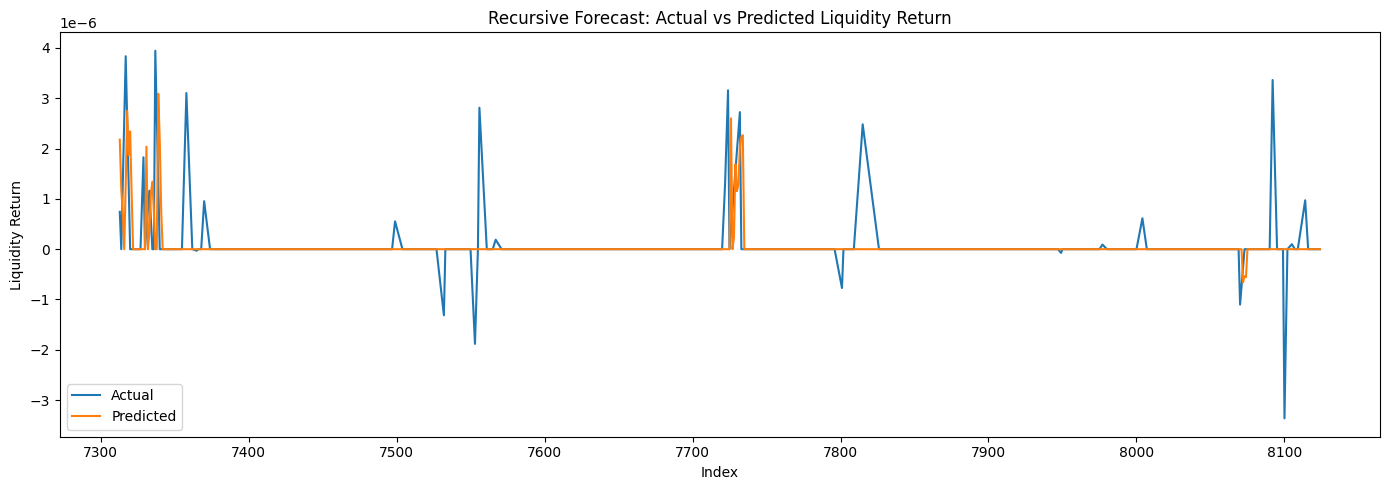

In [44]:
print(f"Grid search results: {len(grid_results)} configurations evaluated")
print(f"Best parameters: {best_params}")

forecast_horizon = int(len(df_fe) * (1-test_split))  # Forecast horizon is the last 20% of the test set
print(f"Forecast horizon: {forecast_horizon} steps")
n_lags = best_params['n_lags']

df_fe = feature_engineering(df)
df_fe_lagged = add_lagged_features(df_fe, n_lags=n_lags)

features = base_features \
    + [f'price_return_lag{lag}' for lag in range(1, n_lags + 1)] \
    + [f'liquidity_return_lag{lag}' for lag in range(1, n_lags + 1)]

preds = best_zir.recursive_forecast(
    df=df_fe_lagged,
    features=features,
    forecast_horizon=forecast_horizon
)

plot_actual_vs_predicted(
    y_true=df_fe_lagged['liquidity_return'].iloc[-forecast_horizon:],
    y_pred=preds,
    title="Recursive Forecast: Actual vs Predicted Liquidity Return"
)

## RNN Regression with PyTorch: Predicting Liquidity Return

We now fit a simple RNN (LSTM) regression model using PyTorch to predict the next-step liquidity return from lagged and engineered features. The RNN is trained incrementally on all pools, similar to the previous regressions.

In [38]:
# import torch
# import torch.nn as nn
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import ParameterGrid
# from torch.utils.data import Dataset, DataLoader

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# epochs = 30

# class LSTMRegressor(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 1, bias=False)  # No bias to reduce constant offset

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         return self.fc(out[:, -1, :]).squeeze()

# class SequenceDataset(Dataset):
#     def __init__(self, X, y, seq_len):
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y = torch.tensor(y, dtype=torch.float32)
#         self.seq_len = seq_len

#     def __len__(self):
#         return len(self.X) - self.seq_len

#     def __getitem__(self, idx):
#         return (
#             self.X[idx:idx + self.seq_len],
#             self.y[idx + self.seq_len]
#         )

# def prepare_data(n_lags, features):
#     df_fe = feature_engineering(df)
#     df_fe = add_lagged_features(df_fe, n_lags=n_lags)
#     train_df, _ = get_chronological_split(df_fe, split=test_split)

#     X_train = train_df[features]
#     y_train = train_df['liquidity_return']
#     mask = X_train.notnull().all(axis=1) & y_train.notnull()
#     X_train = X_train[mask]
#     y_train = y_train.loc[mask]

#     mask = X_train.notnull().all(axis=1) & y_train.notnull()
#     X_train = X_train[mask]
#     y_train = y_train[mask]

#     X_val = X_train[len(X_train) // 5:]  # Use last 20% for validation
#     y_val = y_train[len(y_train) // 5:]

#     X_scaler = StandardScaler()
#     y_scaler = StandardScaler()

#     X_train = X_scaler.fit_transform(X_train)
#     X_val = X_scaler.transform(X_val)

#     y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
#     y_val = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

#     return X_train, X_val, y_train, y_val, X_scaler, y_scaler

# print("Finished preparing data. Starting grid search...")

# # Grid search
# best_score = float('inf')
# best_params = None

# for params in ParameterGrid({
#     'n_lags': [3, 5, 8],
#     'hidden_size': [4, 8, 16],
#     'batch_size': [16],
# }):
#     print("Starting new iteration...")
#     print(f"Params: {params}")
#     n_lags = params['n_lags']
#     features = base_features + [f'{kind}_return_lag{lag}' for kind in ['price', 'liquidity'] for lag in range(1, n_lags + 1)]

#     X_train, X_val, y_train, y_val, X_scaler, y_scaler = prepare_data(n_lags, features)
#     if X_train is None:
#         continue

#     train_dataset = SequenceDataset(X_train, y_train, n_lags)
#     val_dataset = SequenceDataset(X_val, y_val, n_lags)
#     train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)
#     val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

#     model = LSTMRegressor(input_size=X_train.shape[1], hidden_size=params['hidden_size']).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = nn.SmoothL1Loss()  # More robust to outliers

#     for epoch in range(epochs):
#         model.train()
#         for X_batch, y_batch in train_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()
#             loss = criterion(model(X_batch), y_batch)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     preds, trues = [], []
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch = X_batch.to(device)
#             output = model(X_batch).cpu().numpy()
#             preds.append(output)
#             trues.append(y_batch.numpy())

#     y_pred_scaled = np.concatenate(preds)
#     y_true_scaled = np.concatenate(trues)

#     # Inverse transform
#     y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
#     y_true = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()

#     print(f"Mean true: {y_true.mean():.5f}, Mean pred: {y_pred.mean():.5f}")

#     score = evaluate_predictions(y_true, y_pred)['RMSE']
#     print(f"Val RMSE: {score}")

#     if score < best_score:
#         best_score = score
#         best_params = params
#         best_pred = y_pred

# print(f"Best LSTM params: {best_params}, Best Val RMSE: {best_score}")


In [39]:
# # Plot for RNN Model
# plot_actual_vs_predicted(pd.Series(y_true[:100]), pd.Series(y_pred[:100]), title="RNN (LSTM): Actual vs Predicted Liquidity Return")

## Vector Autoregression (VAR) Model

This section implements a simple VAR model using the `statsmodels` library. The autoregressive part is the liquidity returns (and their lags), while the price returns (and their lags) are always available as exogenous variables.

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

n_lags = 10  # Number of lags to use for SARIMAX

# Feature engineering and lagging
df_fe = feature_engineering(df)  
df_fe = add_lagged_features(df_fe, n_lags=n_lags)

# Define features
exog_cols = base_features + [f'price_return_lag{lag}' for lag in range(1, n_lags + 1)]
endog_col = 'liquidity_return'
liquidity_lags = [f'liquidity_return_lag{lag}' for lag in range(1, n_lags + 1)]

# Drop NaNs
mask = df_fe[[endog_col] + exog_cols + liquidity_lags].notnull().all(axis=1)
df_fe = df_fe.loc[mask].reset_index(drop=True)

# Target
y = df_fe[endog_col]
X = df_fe[exog_cols]

# Chronological train-test split
split = int(len(df_fe) * test_split)
y_train, y_test = y.iloc[:split], y.iloc[split:]
X_train, X_test = X.iloc[:split], X.iloc[split:]

# SARIMAX: AR terms via order=(p,d,q)
# Here: AR(p=3), no integration (d=0), no MA (q=0)
model = SARIMAX(y_train, exog=X_train, order=(n_lags, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)

# # Forecast
# forecast = result.predict(start=split, end=len(df)-1, exog=X_test)
# ### TECHNICALLY THIS IS CHEATING, AS WE ARE USING Liquidity MAs and volatilities that were computed on the entire dataset.

# # Evaluate
# mae = mean_absolute_error(y_test, forecast)
# rmse = mean_squared_error(y_test, forecast)
# print(f"SARIMAX results for liquidity_return_next: MAE={mae:}, RMSE={rmse}")
# plot_actual_vs_predicted(
#     y_true=y_test,
#     y_pred=result.predict(start=split, end=len(df_fe)-1, exog=X_test),
#     title="SARIMAX: Actual vs Predicted Liquidity Return"
# )


/home/janmarxen/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
# plt.figure(figsize=(12, 6))
# plt.plot(y_test.values[:100], label='True', color='black')
# plt.plot(forecast.values[:100], label='Predicted', color='blue', linestyle='--')
# plt.title("Liquidity Return: True vs Predicted (SARIMAX)")
# plt.xlabel("Time")
# plt.ylabel("Liquidity Return")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


## Recursive Forecasting with Autoregressive Liquidity Features

When forecasting multiple steps ahead, you must update liquidity-based features (MAs, volatilities) at each step using only available data: true values up to the forecast start, and your own predictions for future steps. This avoids lookahead bias and simulates real deployment.

Below is an example of how to perform recursive forecasting with rolling liquidity features, using your trained model and updating features step by step.

In [42]:
# Example: Recursive multi-step forecasting with autoregressive liquidity features

# def recursive_forecast_with_rolling_features(model, df, features, forecast_horizon=20, n_lags=10):
#     """
#     Recursive multi-step forecast using SARIMAX, updating autoregressive features.
    
#     Parameters:
#         model: fitted SARIMAXResults object
#         df: full DataFrame including future true exogenous variables
#         features: list of exogenous feature columns
#         forecast_horizon: number of future steps to forecast
#         n_lags: number of liquidity lags used as features
    
#     Returns:
#         List of predicted liquidity_return values
#     """
#     df = df.copy()
#     preds = []
    
#     # Initialize history with known part (up to forecast start)
#     history = df.iloc[:-forecast_horizon].copy()
    
#     for step in range(forecast_horizon):
#         last_idx = history.index[-1]
#         next_idx = last_idx + 1  # index of the next step in df
        
#         next_row = {}

#         # Price-based features (assumed known in advance)
#         for col in [c for c in features if c.startswith('price')]:
#             next_row[col] = df.loc[next_idx, col]
        
#         # Time-based features
#         for col in [c for c in ['hour', 'day_of_week', 'month', 'season'] if c in features]:
#             next_row[col] = df.loc[next_idx, col]

#         # Liquidity lag features (from past history)
#         for lag in range(1, n_lags + 1):
#             next_row[f'liquidity_return_lag{lag}'] = history['liquidity_return'].iloc[-lag]
        
#         # Rolling features
#         for win in [3, 6, 24]:
#             if f'liquidity_volatility_{win}h' in features:
#                 next_row[f'liquidity_volatility_{win}h'] = history['liquidity_return'].iloc[-win:].std()
#             if f'liquidity_ma_{win}h' in features:
#                 next_row[f'liquidity_ma_{win}h'] = history['liquidity_return'].iloc[-win:].mean()

#         # Create exogenous input
#         X_next = pd.DataFrame([next_row], index=[next_idx])[features]

#         # Predict using SARIMAX (use dynamic forecasting from current step)
#         # y_next = model.predict(start=len(history), end=len(history), exog=X_next)[0]
#         y_next = model.forecast(steps=1, exog=X_next)[0]

#         preds.append(y_next)

#         # Append the new row with predicted value to history
#         new_row = df.loc[next_idx].copy()
#         new_row['liquidity_return'] = y_next
#         history = pd.concat([history, pd.DataFrame([new_row])])  # preserve index
    
#     return preds

def recursive_forecast_with_rolling_features(model, df, features, forecast_horizon=20, n_lags=5):
    df = df.reset_index(drop=True)
    preds = []
    history = df.iloc[:-forecast_horizon].copy().reset_index(drop=True)
    for step in range(forecast_horizon):
        last_idx = history.index[-1]
        next_idx = last_idx + 1
        next_row = {}
        for col in [c for c in features if c.startswith('price')]:
            next_row[col] = df.iloc[next_idx][col] if next_idx < len(df) else np.nan
        for col in [c for c in ['hour', 'day_of_week', 'month', 'season'] if c in features]:
            next_row[col] = df.iloc[next_idx][col] if next_idx < len(df) else np.nan
        for col in [f'liquidity_ma_{win}h' for win in [3, 6, 24] if f'liquidity_ma_{win}h' in features]:
            next_row[col] = history['liquidity_return'].iloc[-n_lags:].mean() if len(history) >= n_lags else np.nan
        for col in [f'liquidity_volatility_{win}h' for win in [3, 6, 24] if f'liquidity_volatility_{win}h' in features]:
            next_row[col] = history['liquidity_return'].iloc[-n_lags:].std() if len(history) >= n_lags else np.nan
        X_next = pd.DataFrame([next_row], columns=features)
        print("X_next at step 1:\n", X_next)
        if X_next.isnull().any().any() or np.isinf(X_next.values).any():
            print(f"NaN or inf in exog at step {step+1}, stopping forecast.")
            break
        y_next = model.forecast(steps=1, exog=X_next)[0]
        preds.append(y_next)
        # Create new row for history
        if next_idx < len(df):
            new_row = df.iloc[next_idx].copy()
        else:
            new_row = pd.Series({col: np.nan for col in df.columns})
        new_row['liquidity_return'] = y_next
        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)
        return preds

forecast_horizon = 20

features = base_features + [f'price_return_lag{i}' for i in range(1, n_lags + 1)] 

df_fe = feature_engineering(df)  # Ensure we have all necessary features
df_fe = add_lagged_features(df_fe, n_lags=n_lags)

# Make sure all these features exist in `test_df_fe`
preds = recursive_forecast_with_rolling_features(
    model=result,
    df=df_fe,
    features=exog_cols,
    forecast_horizon=forecast_horizon,
    n_lags=n_lags
)

# Plotting example:
plt.plot(range(forecast_horizon), preds, label='Recursive Forecast')
plt.plot(range(forecast_horizon), df_fe['liquidity_return'].iloc[-forecast_horizon:].values, label='True')
plt.legend(); plt.show()

# This approach ensures that at each step, only information available up to that point (including previous predictions) is used for rolling liquidity features.

X_next at step 1:
    price_return  price_volatility_3h  price_volatility_6h  \
0      0.001008             0.000355             0.000602   

   price_volatility_24h  liquidity_volatility_3h  liquidity_volatility_6h  \
0              0.001045                 0.000001                 0.000001   

   liquidity_volatility_24h  price_ma_3h  price_ma_6h  price_ma_24h  ...  \
0                  0.000001     0.000653     0.000166       0.00044  ...   

   price_return_lag1  price_return_lag2  price_return_lag3  price_return_lag4  \
0           0.000653           0.000298          -0.000057           -0.00032   

   price_return_lag5  price_return_lag6  price_return_lag7  price_return_lag8  \
0          -0.000584          -0.000848           0.001884           0.001942   

   price_return_lag9  price_return_lag10  
0           0.001443              0.0015  

[1 rows x 27 columns]


KeyError: 0